Probabilistic Programming
=====
and Bayesian Methods for Hackers 
========


`Original content created by Cam Davidson-Pilon`

`Ported to Gen by Sergey Kojoian (@heckeop)`
___


Welcome to *Bayesian Methods for Hackers*. The full Github repository is available at [github/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers). The other chapters can be found on the project's [homepage](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/). We hope you enjoy the book, and we encourage any contributions!

Chapter 1
======
***

The Philosophy of Bayesian Inference
------
  
> You are a skilled programmer, but bugs still slip into your code. After a particularly difficult implementation of an algorithm, you decide to test your code on a trivial example. It passes. You test the code on a harder problem. It passes once again. And it passes the next, *even more difficult*, test too! You are starting to believe that there may be no bugs in this code...

If you think this way, then congratulations, you already are thinking Bayesian! Bayesian inference is simply updating your beliefs after considering new evidence. A Bayesian can rarely be certain about a result, but he or she can be very confident. Just like in the example above, we can never be 100% sure that our code is bug-free unless we test it on every possible problem; something rarely possible in practice. Instead, we can test it on a large number of problems, and if it succeeds we can feel more *confident* about our code, but still not certain.  Bayesian inference works identically: we update our beliefs about an outcome; rarely can we be absolutely sure unless we rule out all other alternatives. 


### The Bayesian state of mind


Bayesian inference differs from more traditional statistical inference by preserving *uncertainty*. At first, this sounds like a bad statistical technique. Isn't statistics all about deriving *certainty* from randomness? To reconcile this, we need to start thinking like Bayesians. 

The Bayesian world-view interprets probability as measure of *believability in an event*, that is, how confident we are in an event occurring. In fact, we will see in a moment that this is the natural interpretation of probability. 

For this to be clearer, we consider an alternative interpretation of probability: *Frequentist*, known as the more *classical* version of statistics, assume that probability is the long-run frequency of events (hence the bestowed title). For example, the *probability of plane accidents* under a frequentist philosophy is interpreted as the *long-term frequency of plane accidents*. This makes logical sense for many probabilities of events, but becomes more difficult to understand when events have no long-term frequency of occurrences. Consider: we often assign probabilities to outcomes of presidential elections, but the election itself only happens once! Frequentists get around this by invoking alternative realities and saying across all these realities, the frequency of occurrences defines the probability. 

Bayesians, on the other hand, have a more intuitive approach. Bayesians interpret a probability as measure of *belief*, or confidence, of an event occurring. Simply, a probability is a summary of an opinion. An individual who assigns a belief of 0 to an event has no confidence that the event will occur; conversely, assigning a belief of 1 implies that the individual is absolutely certain of an event occurring. Beliefs between 0 and 1 allow for weightings of other outcomes. This definition agrees with the probability of a plane accident example, for having observed the frequency of plane accidents, an individual's belief should be equal to that frequency, excluding any outside information. Similarly, under this definition of probability being equal to beliefs, it is meaningful to speak about probabilities (beliefs) of presidential election outcomes: how confident are you candidate *A* will win?

Notice in the paragraph above, I assigned the belief (probability) measure to an *individual*, not to Nature. This is very interesting, as this definition leaves room for conflicting beliefs between individuals. Again, this is appropriate for what naturally occurs: different individuals have different beliefs of events occurring, because they possess different *information* about the world. The existence of different beliefs does not imply that anyone is wrong. Consider the following examples demonstrating the relationship between individual beliefs and probabilities:

- I flip a coin, and we both guess the result. We would both agree, assuming the coin is fair, that the probability of Heads is 1/2. Assume, then, that I peek at the coin. Now I know for certain what the result is: I assign probability 1.0 to either Heads or Tails (whichever it is). Now what is *your* belief that the coin is Heads? My knowledge of the outcome has not changed the coin's results. Thus we assign different probabilities to the result. 

-  Your code either has a bug in it or not, but we do not know for certain which is true, though we have a belief about the presence or absence of a bug.  

-  A medical patient is exhibiting symptoms $x$, $y$ and $z$. There are a number of diseases that could be causing all of them, but only a single disease is present. A doctor has beliefs about which disease, but a second doctor may have slightly different beliefs. 


This philosophy of treating beliefs as probability is natural to humans. We employ it constantly as we interact with the world and only see partial truths, but gather evidence to form beliefs. Alternatively, you have to be *trained* to think like a frequentist. 

To align ourselves with traditional probability notation, we denote our belief about event $A$ as $P(A)$. We call this quantity the *prior probability*.

John Maynard Keynes, a great economist and thinker, said "When the facts change, I change my mind. What do you do, sir?" This quote reflects the way a Bayesian updates his or her beliefs after seeing evidence. Even &mdash; especially &mdash; if the evidence is counter to what was initially believed, the evidence cannot be ignored. We denote our updated belief as $P(A |X )$, interpreted as the probability of $A$ given the evidence $X$. We call the updated belief the *posterior probability* so as to contrast it with the prior probability. For example, consider the posterior probabilities (read: posterior beliefs) of the above examples, after observing some evidence $X$:

1\. $P(A): \;\;$ the coin has a 50 percent chance of being Heads. $P(A | X):\;\;$ You look at the coin, observe a Heads has landed, denote this information $X$, and trivially assign probability 1.0 to Heads and 0.0 to Tails.

2\.   $P(A): \;\;$  This big, complex code likely has a bug in it. $P(A | X): \;\;$ The code passed all $X$ tests; there still might be a bug, but its presence is less likely now.

3\.  $P(A):\;\;$ The patient could have any number of diseases. $P(A | X):\;\;$ Performing a blood test generated evidence $X$, ruling out some of the possible diseases from consideration.


It's clear that in each example we did not completely discard the prior belief after seeing new evidence $X$, but we *re-weighted the prior* to incorporate the new evidence (i.e. we put more weight, or confidence, on some beliefs versus others). 

By introducing prior uncertainty about events, we are already admitting that any guess we make is potentially very wrong. After observing data, evidence, or other information, we update our beliefs, and our guess becomes *less wrong*. This is the alternative side of the prediction coin, where typically we try to be *more right*. 



### Bayesian Inference in Practice

 If frequentist and Bayesian inference were programming functions, with inputs being statistical problems, then the two would be different in what they return to the user. The frequentist inference function would return a number, representing an estimate (typically a summary statistic like the sample average etc.), whereas the Bayesian function would return *probabilities*.

For example, in our debugging problem above, calling the frequentist function with the argument "My code passed all $X$ tests; is my code bug-free?" would return a *YES*. On the other hand, asking our Bayesian function "Often my code has bugs. My code passed all $X$ tests; is my code bug-free?" would return something very different: probabilities of *YES* and *NO*. The function might return:


>    *YES*, with probability 0.8; *NO*, with probability 0.2



This is very different from the answer the frequentist function returned. Notice that the Bayesian function accepted an additional argument:  *"Often my code has bugs"*. This parameter is the *prior*. By including the prior parameter, we are telling the Bayesian function to include our belief about the situation. Technically this parameter in the Bayesian function is optional, but we will see excluding it has its own consequences. 


#### Incorporating evidence

As we acquire more and more instances of evidence, our prior belief is *washed out* by the new evidence. This is to be expected. For example, if your prior belief is something ridiculous, like "I expect the sun to explode today", and each day you are proved wrong, you would hope that any inference would correct you, or at least align your beliefs better. Bayesian inference will correct this belief.


Denote $N$ as the number of instances of evidence we possess. As we gather an *infinite* amount of evidence, say as $N \rightarrow \infty$, our Bayesian results (often) align with frequentist results. Hence for large $N$, statistical inference is more or less objective. On the other hand, for small $N$, inference is much more *unstable*: frequentist estimates have more variance and larger confidence intervals. This is where Bayesian analysis excels. By introducing a prior, and returning probabilities (instead of a scalar estimate), we *preserve the uncertainty* that reflects the instability of statistical inference of a small $N$ dataset. 

One may think that for large $N$, one can be indifferent between the two techniques since they offer similar inference, and might lean towards the computationally-simpler, frequentist methods. An individual in this position should consider the following quote by Andrew Gelman (2005)[1], before making such a decision:

> Sample sizes are never large. If $N$ is too small to get a sufficiently-precise estimate, you need to get more data (or make more assumptions). But once $N$ is "large enough," you can start subdividing the data to learn more (for example, in a public opinion poll, once you have a good estimate for the entire country, you can estimate among men and women, northerners and southerners, different age groups, etc.). $N$ is never enough because if it were "enough" you'd already be on to the next problem for which you need more data.

### Are frequentist methods incorrect then? 

**No.**

Frequentist methods are still useful or state-of-the-art in many areas. Tools such as least squares linear regression, LASSO regression, and expectation-maximization algorithms are all powerful and fast. Bayesian methods complement these techniques by solving problems that these approaches cannot, or by illuminating the underlying system with more flexible modeling.


#### A note on *Big Data*
Paradoxically, big data's predictive analytic problems are actually solved by relatively simple algorithms [2][4]. Thus we can argue that big data's prediction difficulty does not lie in the algorithm used, but instead on the computational difficulties of storage and execution on big data. (One should also consider Gelman's quote from above and ask "Do I really have big data?")

The much more difficult analytic problems involve *medium data* and, especially troublesome, *really small data*. Using a similar argument as  Gelman's above, if big data problems are *big enough* to be readily solved, then we should be more interested in the *not-quite-big enough* datasets. 


### Our Bayesian framework

We are interested in beliefs, which can be interpreted as probabilities by thinking Bayesian. We have a *prior* belief in event $A$, beliefs formed by previous information, e.g., our prior belief about bugs being in our code before performing tests.

Secondly, we observe our evidence. To continue our buggy-code example: if our code passes $X$ tests, we want to update our belief to incorporate this. We call this new belief the *posterior* probability. Updating our belief is done via the following equation, known as Bayes' Theorem, after its discoverer Thomas Bayes:

\begin{align}
 P( A | X ) = & \frac{ P(X | A) P(A) } {P(X) } \\\\[5pt]
& \propto P(X | A) P(A)\;\; (\propto \text{is proportional to })
\end{align}

The above formula is not unique to Bayesian inference: it is a mathematical fact with uses outside Bayesian inference. Bayesian inference merely uses it to connect prior probabilities $P(A)$ with an updated posterior probabilities $P(A | X )$.

##### Example: Mandatory coin-flip example

Every statistics text must contain a coin-flipping example, I'll use it here to get it out of the way. Suppose, naively, that you are unsure about the probability of heads in a coin flip (spoiler alert: it's 50%). You believe there is some true underlying ratio, call it $p$, but have no prior opinion on what $p$ might be. 

We begin to flip a coin, and record the observations: either $H$ or $T$. This is our observed data. An interesting question to ask is how our inference changes as we observe more and more data? More specifically, what do our posterior probabilities look like when we have little data, versus when we have lots of data. 

Below we plot a sequence of updating posterior probabilities as we observe increasing amounts of data (coin flips).

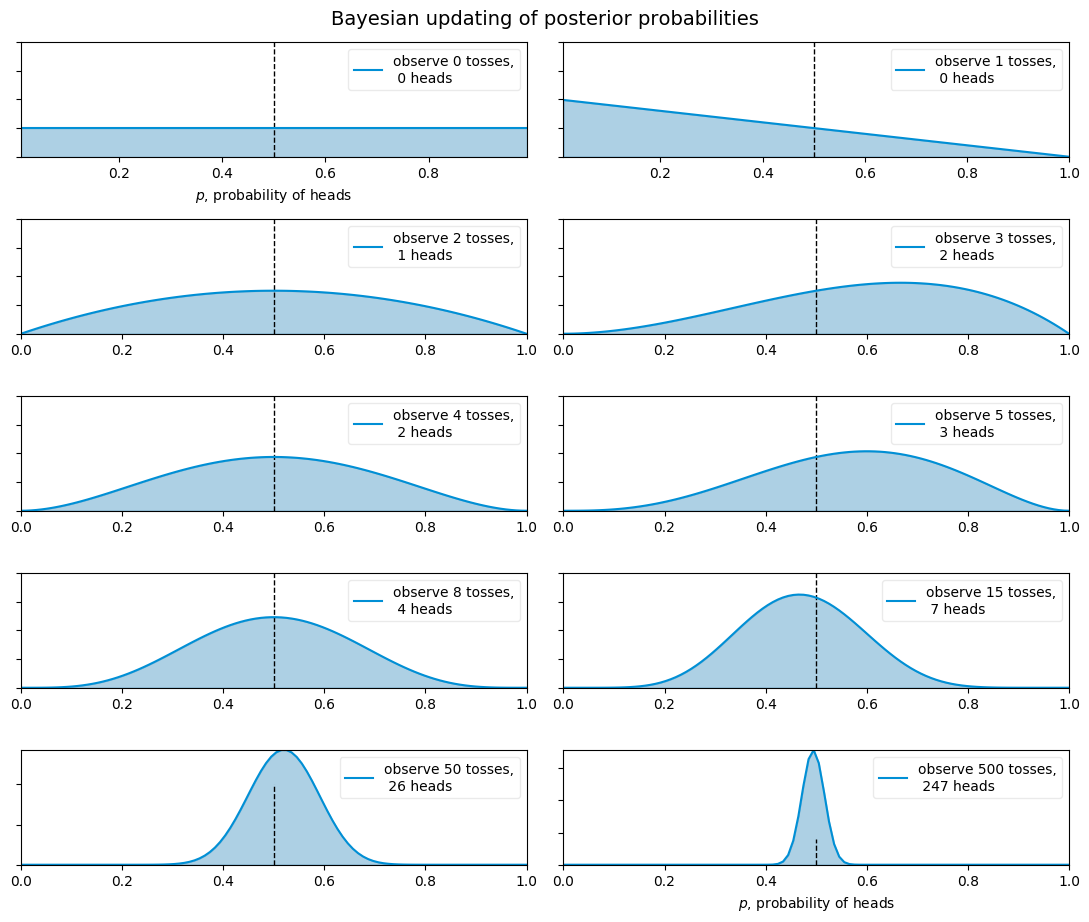

In [1]:
"""
The book uses a custom matplotlibrc file, which provides the unique styles for
matplotlib plots. If executing this book, and you wish to use the book's
styling, provided are two options:
    1. Overwrite your own matplotlibrc file with the rc-file provided in the
       book's styles/ dir. See http://matplotlib.org/users/customizing.html
    2. Also in the styles is  bmh_matplotlibrc.json file. This can be used to
       update the styles in only this notebook. Try running the following code:

        import JSON
        using PyCall
        s = open("../styles/bmh_matplotlibrc.json") do file
            read(file, String)
        end
        rcParams = PyCall.PyDict(matplotlib."rcParams")
        merge!(rcParams, JSON.parse(s))

"""

# The code below can be passed over, as it is currently not important, plus it
# uses advanced topics we have not covered yet. LOOK AT PICTURE, MICHAEL!
using PyPlot
using Gen
figure(figsize=(11, 9))


n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = [Gen.bernoulli(0.5) for _=1:n_trials[end]]
x = range(0,stop=1,length=100)

# For the already prepared, I'm using Binomial's conj. prior.
for (k, N) in enumerate(n_trials)
    sx = subplot(length(n_trials)/2, 2, k)
    heads = sum(data[1:N])
    xlabel(if k in [1, length(n_trials)] "\$p\$, probability of heads" else nothing end)
    setp(sx.get_yticklabels(), visible=false)
    
    y = [exp(Gen.logpdf(Gen.beta, v, 1 + heads, 1 + N - heads)) for v in x]
    plot(x, y, label="observe $N tosses,\n $heads heads")
    fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = legend()
    leg.get_frame().set_alpha(0.4)
    autoscale(tight=true)
end

suptitle("Bayesian updating of posterior probabilities",
         y=1.02,
         fontsize=14)

tight_layout()

The posterior probabilities are represented by the curves, and our uncertainty is proportional to the width of the curve. As the plot above shows, as we start to observe data our posterior probabilities start to shift and move around. Eventually, as we observe more and more data (coin-flips), our probabilities will tighten closer and closer around the true value of $p=0.5$ (marked by a dashed line). 

Notice that the plots are not always *peaked* at 0.5. There is no reason it should be: recall we assumed we did not have a prior opinion of what $p$ is. In fact, if we observe quite extreme data, say 8 flips and only 1 observed heads, our distribution would look very biased *away* from lumping around 0.5 (with no prior opinion, how confident would you feel betting on a fair coin after observing 8 tails and 1 head?). As more data accumulates, we would see more and more probability being assigned at $p=0.5$, though never all of it.

The next example is a simple demonstration of the mathematics of Bayesian inference. 

##### Example: Bug, or just sweet, unintended feature?


Let $A$ denote the event that our code has **no bugs** in it. Let $X$ denote the event that the code passes all debugging tests. For now, we will leave the prior probability of no bugs as a variable, i.e. $P(A) = p$. 

We are interested in $P(A|X)$, i.e. the probability of no bugs, given our debugging tests $X$. To use the formula above, we need to compute some quantities.

What is $P(X | A)$, i.e., the probability that the code passes $X$ tests *given* there are no bugs? Well, it is equal to 1, for a code with no bugs will pass all tests. 

$P(X)$ is a little bit trickier: The event $X$ can be divided into two possibilities, event $X$ occurring even though our code *indeed has* bugs (denoted $\sim A\;$, spoken *not $A$*), or event $X$ without bugs ($A$). $P(X)$ can be represented as:

\begin{align}
P(X ) & = P(X \text{ and } A) + P(X \text{ and } \sim A) \\\\[5pt]
 & = P(X|A)P(A) + P(X | \sim A)P(\sim A)\\\\[5pt]
& = P(X|A)p + P(X | \sim A)(1-p)
\end{align}

We have already computed $P(X|A)$ above. On the other hand, $P(X | \sim A)$ is subjective: our code can pass tests but still have a bug in it, though the probability there is a bug present is reduced. Note this is dependent on the number of tests performed, the degree of complication in the tests, etc. Let's be conservative and assign $P(X|\sim A) = 0.5$. Then

\begin{align}
P(A | X) & = \frac{1\cdot p}{ 1\cdot p +0.5 (1-p) } \\\\
& = \frac{ 2 p}{1+p}
\end{align}
This is the posterior probability. What does it look like as a function of our prior, $p \in [0,1]$? 

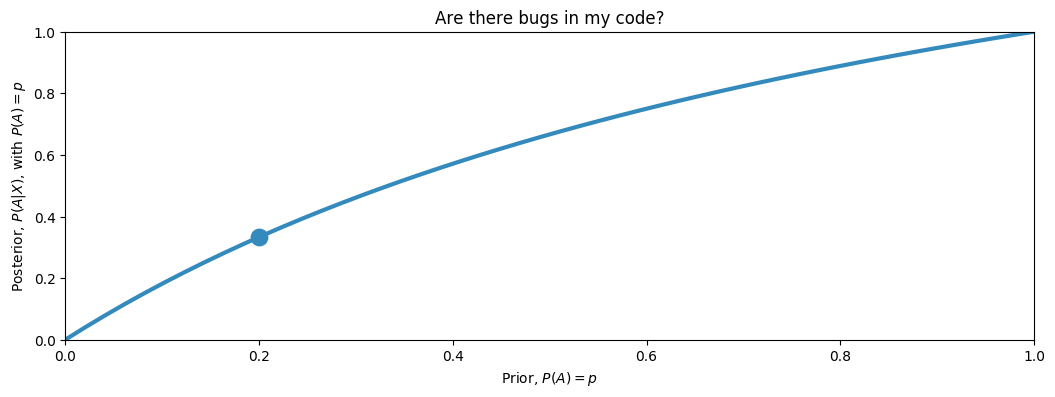

In [2]:
figure(figsize=(12.5, 4))
p = range(0, stop=1, length=50)
plot(p, 2 .* p ./ (1 .+ p), color="#348ABD", lw=3)
scatter(0.2, 2*(0.2)/1.2, s=140, c="#348ABD")
xlim(0, 1)
ylim(0, 1)
xlabel("Prior, \$P(A) = p\$")
ylabel("Posterior, \$P(A|X)\$, with \$P(A) = p\$")
title("Are there bugs in my code?");